## Music Genre Classification through Image Processing and Generation <br> (Enhanced with Evolutionary Algorithms)
*by Chomba Mumba*

## Table Of Contents
1. [Abstract](#abstract)
1. [Learning Objectives](#learning-objectives)
1. [Convolution Neural Network Architecture](#cnn-architecture)
1. [Helper Functions](#helper-functions)
    * [Create Spectograms](#create-spectograms)
    * [Copy Tracks by Genres](#copy-tracks-by-genres)
    * [Distribute Files](#distribute-files)
1. [Create and Distribute Spectograms](#create-and-distribute-spectograms)
1. [Data Loading](#helper-functions)
1. [Model Training](#helper-functions)
    * [Training Function](#training-function)
    * [Training Device](#training-device)
    * [Train Model](#train-model)
1. [Model Evaluation](#model-evaluation)
    * [Accuracy During Training](#accuracy-during-training)
    * [Actual vs Predicted](#actual-vs-predicted)
1. [Genetic Algorithm](#genetic-algorithm)
1. [Improved Model Evaluation](#improved-model-evaluation)
    * [Accuracy During Training](#improved-accuracy-during-training)
    * [Actual vs Predicted](#improved-accuracy-during-traing)

## Abstract
Deep learning architectures such as Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs),  offer powerful methods for sound classification, with CNNs excelling at capturing intracate audio features. This tutorial Centres on the extraction of information from audio clips, particularly focusing on musical genres. Spectograms, which are visual representations of sound frequencies and waveforms, can be used for sound classificaiton and serve as the basis for this machine learning pipeline. The tutorial will construct a model for music genre classification, utiizing a CNN analyse our generated spectograms derived off audio clips sourced form the Free Music Archive, available on Kaggle. The tutorial then optimizes our CNNs hyperparameters to improve prediction by utilizing a genetic algorithm.

## Learning Objectives
- Understand the fundamentals of deep learning architectures, including Convolutional Neural Networks (CNNs).
- Gain proficiency in utilizing CNNs for sound classification tasks.
- Learn the concept and practical application of spectrograms as visual representations of sound frequencies and waveforms.
- Learn how to preprocess audio data, generate spectrograms, and prepare them for input into the CNN model.
- Gain proficiency in analyzing and interpreting results obtained from the classification model.
- Understand the basics of Genetic algorithms and applying them to optimize model hyperparameters.
- Develop problem-solving skills in optimizing model performance and addressing challenges encountered during the classification process.

The contents of this tutorial are inspired by the following tutorials by *Nueromatch Academy* and respectively:
Music classification and generation with Spectograms

Sound classification has numerous real world applications such as:
- Speech Recognition
- Music Information Retrieval
- Healthcare
- Automotive Maintencance


In [2]:
import os
import matplotlib.pyplot as plt

import librosa
import librosa.display

import IPython.display as ipd
import pandas as pd
import numpy as np
import random
import shutil
from tqdm.notebook import tqdm
import ipywidgets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms


from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from deap import base, creator, tools, algorithms

C:\Users\Chomba Mumba\AppData\Local\Temp\ipykernel_12488\1425243518.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## CNN Architecture

In [18]:
class CNNNetwork(nn.Module): #kernel_size = 3, stride = 1, padding = 0
    def __init__(self, kernel_sizes, stride_ranges, padding_ranges):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 3,
                out_channels = 8,
                kernel_size = kernel_sizes[0],
                stride = stride_ranges[0],
                padding = padding_ranges[0],
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            # nn.BatchNorm2d(8)
        )   
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 8,
                out_channels = 16,
                kernel_size = kernel_sizes[1],
                stride = stride_ranges[1],
                padding = padding_ranges[1],
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            # nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = kernel_sizes[2],
                stride = stride_ranges[2],
                padding = padding_ranges[2],
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            # nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels = 32,
                out_channels = 64,
                kernel_size = kernel_sizes[3],
                stride = stride_ranges[3],
                padding = padding_ranges[3],
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            # nn.BatchNorm2d(64)
            
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)

        # Calculate input size for linear layer
        x = torch.zeros(1, 3, 800, 300)  # Assuming input dimensions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        size = x.shape[1]
        
        # Create the linear layer
        self.linear = nn.Linear(size, 163)
        del size
        del x
        # self.linear = nn.Linear(49152, 163)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x) 

        x = self.flatten(x)
        x = self.dropout(x)
        logits = self.linear(x)
        # logits = F.softmax(logits, dim=1)
        return logits

## Helper Functions

*Create Spectograms*

In [6]:
def create_spectrogram(audio_path, audio_file, destination):
    audio_file = os.path.join(audio_path, audio_file)

    # Load audio file
    x, sr = librosa.load(audio_file, sr=44100)

    # Create and display a spectogram with axis labels
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(frameon=False)
    plt.figure(figsize=(8, 3))
    librosa.display.specshow(Xdb, sr=sr)
 
    # remove axes and title for PNG
    plt.title('')
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    spectogram = plt.gcf()
    plt.close()
    spectogram.savefig(destination, transparent=True, bbox_inches='tight', pad_inches=0.0)
    return spectogram

*Copy Track By Genre*

In [ ]:
def copy_track_by_genres(directory, tracks_df):
    import ast
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            track_id = filename.split("_")[0].lstrip("0")
            temp = tracks_df.loc[tracks_df['track_id'] == track_id, 'genres_all']
            if not temp.empty:
                genres_for_track = tracks_df.loc[tracks_df['track_id'] == track_id, 'genres_all'].values[0]
                if not pd.isna(genres_for_track): # ensure genres are not empty
                    genres_list = ast.literal_eval(genres_for_track)
                    for genre in genres_list:
                        genre_folder = os.path.join(directory, str(genre))
                        os.makedirs(genre_folder, exist_ok=True)
                        shutil.copy2(os.path.join(directory, filename), os.path.join(genre_folder, filename))
                else:
                    print(f"Track {track_id} has no genres")

*Distribute Files*

In [78]:
def distribute_files(source_dir, train_dir, test_dir, val_dir):
    files = os.listdir(source_dir)
    random.shuffle(files)

    total_files = len(files)
    train_size = int(0.8 * total_files)
    test_size = int(0.1 * total_files)

    for directory in [train_dir, test_dir, val_dir]:
        os.makedirs(directory, exist_ok=True)

    # Move files to training folder
    for filename in files[:train_size]:
        if filename.endswith(".png"):
            source_path = os.path.join(source_dir, filename)
            dest_path = os.path.join(train_dir, filename)
            shutil.move(source_path, dest_path)

    # Move files to testing folder
    for filename in files[train_size:train_size + test_size]:
        if filename.endswith(".png"):
            source_path = os.path.join(source_dir, filename)
            dest_path = os.path.join(test_dir, filename)
            shutil.move(source_path, dest_path)

    # Move files to validation folder
    for filename in files[train_size + test_size:]:
        if filename.endswith(".png"):
            source_path = os.path.join(source_dir, filename)
            dest_path = os.path.join(val_dir, filename)
            shutil.move(source_path, dest_path)

Plot Loss Accuracy

In [44]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

create source directories (Y)
create spectograms from sound files (y)
distribute files
train model (Y)
evaluate model (Y)

## Create and Distribute Spectograms

In [4]:
folders = []
source_dir = 'spectograms'
train_dir = 'spectograms/training_data'
test_dir = 'spectograms/test_data'
val_dir = 'spectograms/validation_data'
folders.append(source_dir)
folders.append(train_dir)
folders.append(test_dir)
folders.append(val_dir)

In [ ]:
for folder in folders:
    os.makedirs(folder, exist_ok=True)

In [ ]:
folder_path = os.path.join("fma_archive/fma_small/fma_small/")
audio_files = []

for audio_file in os.listdir(folder_path):
    if audio_file != "README.txt" and audio_file != "checksums":
        audio_files.append(audio_file)

## change 

*Create Spectograms of the Audio Files in fma_small/fma_small/*

In [ ]:
for folder in audio_files[128:]:
    current_folder = folder_path + folder  
    for file in os.listdir(current_folder):
        temp_file = file.replace('.mp3', '')
        temp_file += '_spectogram.png'
        spectogram = create_spectrogram(current_folder, file, temp_file)
        plt.clf()
        plt.cla()
        plt.close(spectogram)
        del spectogram, temp_file

In [5]:
tracks = pd.read_csv('fma_archive/fma_metadata/tracks.csv', low_memory=False)
genres = pd.read_csv('fma_archive/fma_metadata/genres.csv', low_memory=False)
genres_df = genres[['genre_id', 'title']]
tracks_df = tracks[['track_id', 'genres_all', 'title']]

# distribute_files(source_dir, train_dir, test_dir, val_dir)

Now we split our spectograms into their different data sets to be used for the model and genetic algorithm.

In [ ]:
files = [f for f in os.listdir(source_dir) if f.endswith('.png')] #file is every file in the spectograms directory

random.shuffle(files)
total_files = len(files)
train_split = int(0.8 * total_files)
test_split = int(0.1 * total_files)

distribute_files(train_split, test_split, files, source_dir, train_dir, test_dir, val_dir)

In [27]:
copy_track_by_genres(train_dir, tracks_df)
copy_track_by_genres(val_dir, tracks_df)
copy_track_by_genres(test_dir, tracks_df)

Track 6674 has no genres
Track 6680 has no genres
Track 46043 has no genres


## Data Loading

In [6]:
train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=25, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)


## Training the Model

Next we define the training function for our model, this function was obtained from the tutorial by Neuromatch Academy with an added early stopping functionality to reduce training time, the will keep training untill the validation loss has not improved for 10 epochs. 

In [7]:
def train(model, device, train_loader, validation_loader, epochs, holdout=20):

  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  best_validation_loss = float('inf')
  consecutive_no_improv = 0
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss.detach().cpu().item()/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      torch.no_grad() #disable gradient calculation to improve efficency - Chomba
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() 
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      val_loss = running_loss/len(validation_loader)
      validation_loss.append(val_loss)
      validation_acc.append(correct/total)
      print(val_loss, best_validation_loss)

      if val_loss < best_validation_loss:
        best_validation_loss = val_loss
        consecutive_no_improv = 0
      else:
        consecutive_no_improv += 1
      
      if consecutive_no_improv >= holdout:
        print(f'No improvement for {holdout} epochs, stopping training early.')
        break

  return train_loss, train_acc, validation_loss, validation_acc

*Define Training Device*

Before we get to training we are going to set the device to be used for training our Neural Network. If you have an Nvidia GPU that supports CUDA ensure you have installed Pytorch with CUDA enabled and the **appropiate CUDA version** (Instructions for this can be found in the CUDA documentation). To check if your GPU is adequate and the right version of CUDA to install, please read [here](https://en.wikipedia.org/wiki/CUDA#GPUs_supported). Doing this properly will allow you to use your to train your CNN using your GPU which will be much faster. From my personal experience training on both my CPU and GPU the training time went from 950s an epoch to 150s an epoch (**~84% increase in training speed**).

In [8]:
print(torch.cuda.get_device_name(0)) #The following will print the name of your GPU if you have an appropriate NVIDIA GPU and cuda is installed correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NVIDIA GeForce GTX 1650 Ti


*Train Model*

In [8]:
torch.cuda.empty_cache()

In [19]:
kernel_sizes = [3, 3, 3, 3]
stride_values = [1, 1, 1, 1]
padding_values = [0, 0, 0, 0]

cnn = CNNNetwork(kernel_sizes, stride_values, padding_values).to(device)
train_loss, train_acc, validation_loss, validation_acc = train(cnn, device, train_loader, val_loader, 100)
train_loss, train_acc, validation_loss, validation_acc

  0%|          | 0/100 [00:00<?, ?epoch/s]

5.790712567262871 inf
5.848993367927019 5.790712567262871
6.077906808187795 5.790712567262871


KeyboardInterrupt: 

## Model Evaluation

*Accuracy During Training*

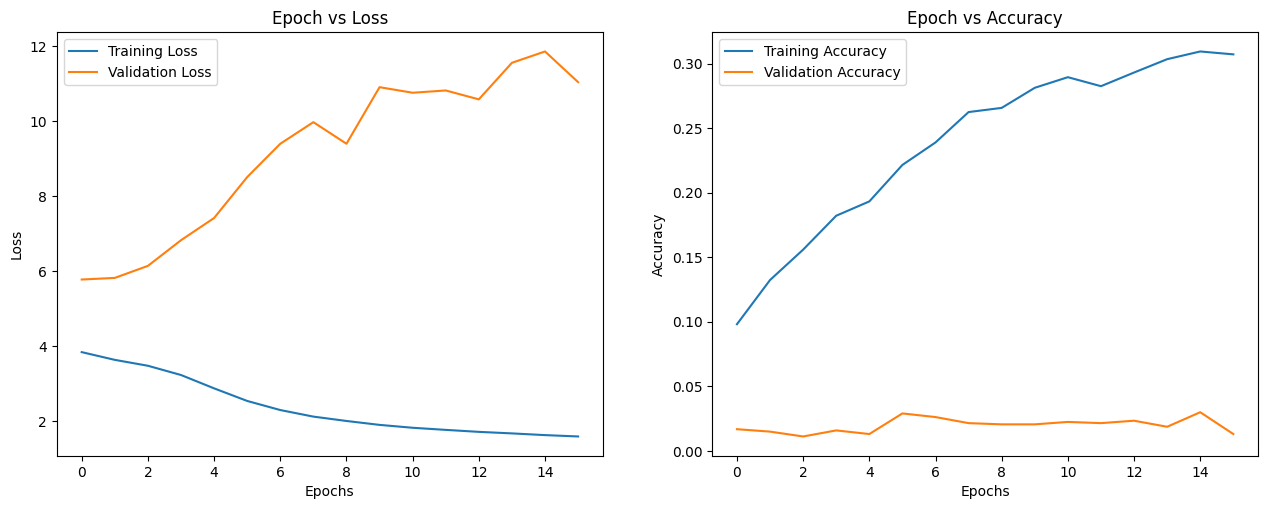

In [45]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

*Actual VS Predicted Values*

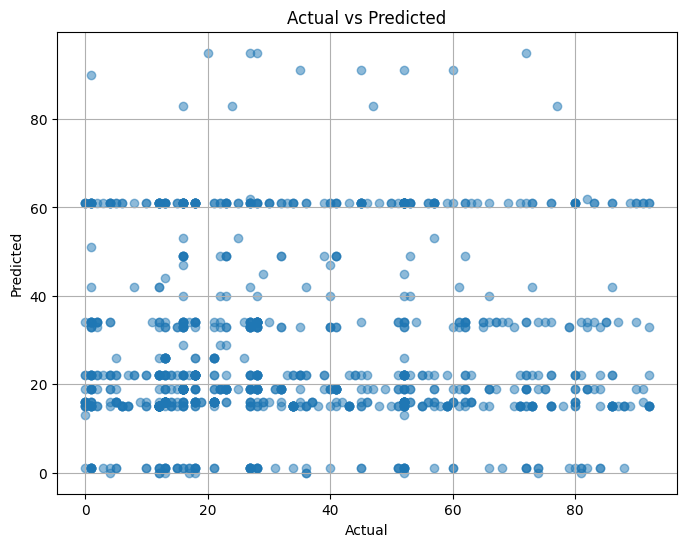

In [29]:
actual_values = []
predicted_values = []
for data, target in val_loader:
    data = data.to(device)
    output = cnn(data)
    _, predicted = torch.max(output, 1)
    actual_values.extend(target.numpy())
    predicted_values.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()


In [43]:
difference = predicted_values - actual_values
len(difference), len(actual_values), len(predicted_values)


(1065, 1065, 1065)

In [53]:
train_targets = []
for _, target in train_loader:
    train_targets.extend(target.numpy())

print(train_targets)

# diff = np.array(train_targets) - actual_values
# len(diff)

[16, 44, 15, 15, 16, 51, 15, 5, 106, 34, 28, 33, 83, 28, 10, 22, 1, 1, 48, 19, 16, 29, 74, 1, 34, 22, 15, 86, 78, 28, 4, 42, 34, 1, 19, 95, 50, 43, 34, 1, 15, 95, 95, 34, 48, 54, 15, 16, 76, 16, 57, 33, 5, 72, 34, 47, 92, 19, 22, 27, 43, 26, 40, 19, 47, 22, 62, 22, 1, 53, 34, 36, 45, 95, 15, 61, 33, 1, 17, 53, 103, 98, 62, 9, 1, 50, 0, 1, 15, 1, 18, 61, 19, 34, 90, 61, 0, 16, 61, 19, 56, 18, 51, 2, 90, 49, 15, 61, 47, 36, 43, 42, 34, 19, 19, 29, 1, 33, 33, 15, 31, 19, 33, 65, 22, 108, 66, 83, 16, 15, 44, 61, 34, 65, 1, 15, 48, 1, 40, 72, 19, 16, 1, 16, 40, 15, 51, 86, 22, 22, 1, 70, 98, 61, 50, 15, 55, 22, 39, 2, 33, 0, 50, 18, 29, 26, 16, 22, 19, 22, 34, 17, 27, 83, 34, 61, 51, 22, 34, 0, 53, 61, 95, 95, 8, 61, 16, 61, 34, 51, 33, 109, 17, 16, 16, 37, 44, 61, 50, 90, 17, 85, 18, 16, 42, 15, 16, 22, 22, 98, 12, 22, 2, 61, 26, 22, 61, 61, 95, 86, 22, 1, 83, 81, 50, 19, 103, 1, 19, 19, 73, 61, 49, 34, 98, 42, 87, 95, 33, 62, 72, 63, 83, 109, 19, 72, 40, 10, 34, 29, 15, 39, 61, 95, 66, 26

In [63]:
val_targets = []
for _, target in val_loader:
    val_targets.extend(target.numpy())

print(set(val_targets))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92}


In [64]:
print(set(train_targets))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110}


In [62]:
train_targets = set(train_targets)
predicted_list = set(val_targets)
len(train_targets), len(predicted_list)
print(train_targets-predicted_list)

{96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 93, 94, 95}


In [39]:
actual_values

array([18, 13, 15, ..., 12, 18, 12], dtype=int64)

## Genetic Algorithm

In [55]:
def evaluate_cnn(individual):
    kernel_sizes = []
    kernel_sizes.append(individual[0])
    kernel_sizes.append(individual[3])
    kernel_sizes.append(individual[6])
    kernel_sizes.append(individual[9])

    stride_values = []
    stride_values.append(individual[1])
    stride_values.append(individual[4])
    stride_values.append(individual[7])
    stride_values.append(individual[10])

    padding_values = []
    padding_values.append(individual[2])
    padding_values.append(individual[5])
    padding_values.append(individual[8])
    padding_values.append(individual[11])

    # Construct your CNN model based on the individual's hyperparameters
    model = CNNNetwork(kernel_sizes, stride_values, padding_values).to(device)
    
    # Train the model and evaluate its performance
    _, accuracy, _, _ = train(model, device, train_loader, val_loader, epochs=10, holdout=5)
    
    # Return the fitness score (higher is better, as we're maximizing)
    return accuracy,

In [56]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()

kernel_sizes = [(3, 5, 7), (3, 5, 7), (3, 5, 7), (3, 5, 7)]
stride_ranges = [(1, 2, 3), (1, 2, 3), (1, 2, 3), (1, 2, 3)]
padding_ranges = [(0, 1, 2), (0, 1, 2), (0, 1, 2), (0, 1, 2)]


def create_individual():
    individual = []
    for ks_range, stride_range, padding_range in zip(kernel_sizes, stride_ranges, padding_ranges):
        individual.append(random.choice(ks_range))  # Randomly choose kernel size
        individual.append(random.choice(stride_range))  # Randomly choose stride
        individual.append(random.choice(padding_range))  # Randomly choose padding
    return individual

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_cnn)


c:\Users\Chomba Mumba\OneDrive - Loughborough University\Uni\4th Year\Advanced AI\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Chomba Mumba\OneDrive - Loughborough University\Uni\4th Year\Advanced AI\.venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [57]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=8, up=64, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_cnn)

In [48]:
population_size = 50
num_generations = 50
population = toolbox.population(n=population_size)

In [58]:
best_solution = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=True)

  0%|          | 0/10 [00:00<?, ?epoch/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (25x5120 and 49152x163)

In [ ]:
best_individual = tools.selBest(population, k=1)[0]
best_individual